#### _Speech Processing Labs 2020: Signals: Module 1_

In [2]:
## Make sure you run this cell before you run the code cells below!
## You can type shift-enter to run a cell and move to the next one
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

import cmath
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

# 2 Digital Signals: Sinusoids and Complex Numbers

### Learning Outcomes
* Develop an intuitive understanding of the relationship between complex numbers, polar coordinates and sinusoids (Euler's formula)
* See that an infinitely long sinusoid in the time-domain can be described as a rotations of vector representing a complex number with specific magnitude and angular frequency (i.e. a phasor)


### Need to know
* Topic Videos: Periodic Signal, Digital Signal
* Sinusoids: $\sin(t)$, $\cos(t)$
    * [a quick trig refresher](https://www.youtube.com/watch?v=2E_O_CR9FA8)
* 2 dimensional vectors and coordinates: 
    * [a great intro to vectors/linear algebra](https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=2&t=7s) 
* degrees and radians: 
    * [a nice video on radians](https://www.youtube.com/watch?v=cgPYLJ-s5II)
    
<div class="alert alert-warning">
<strong>Equation alert</strong>: If you're viewing this on github, please note that the equation rendering is not always perfect. You should view the notebooks through a jupyter notebook server for an accurate view, especially for later notebooks. 
</div>

## 2.0 To the Frequency Domain! 

In the class videos, you've seen that sound waves are changes in air pressure (amplitude) over time. In the previous [notebook](sp-m1-1-sounds-signals.ipynb), we saw that we can characterise differences in sounds, particularly _speech sounds_ based on their pitch and spectrogram.  In the next worksheets, we'll look in more depth at how you can decompose a sound wave into simpler sinusoidal parts and how this gets us the spectrogram.  But to do, we first have to deal with the fact that computers only deal with discrete values.  Going from an continuous (i.e. analogue) to a discrete representation brings up a number of issues that you'll need to be aware of when you deal with speech, e.g. aliasing and spectral leakage. 

To understand why these issues arise, you need to know a little bit about the maths behind how we represent and analyze waveforms. So, this is what these notebooks are about!  But don't worry about reproducing the maths or code here.  The goal is to play with these concepts so that you start to develop some intuitions about what sort of analyses you can do, why you see so many different parameters when you look at Praat settings, and the limitations of these standard digital signal processing methods. 



### Destination: The Discrete Fourier Transform

Tools like Praat make it really easy to look at speech from the perspectives of both the time and frequency domain. 
But if we look 'under the hood', we see that the way we figure out frequency components are present in a specific sound is by using the **Discrete Fourier Transform**.  If you look this up in a text book (e.g. Jurafsky and Martin), you'll see it described like this: 


$$DFT[k] = \sum_{n=0}^{N-1} x[n] e^{j\theta }$$


where, 

$$\theta = k \frac{2 \pi n}{N}$$

So, this is the underlying 'technology' that gets you your spectrogram view in Praat. But, what does this actually mean? And how does it work? Why are there **exponentials** and **complex numbers** in the formula? What does this $\varphi$ term represent? What do you have to think about when you're applying this bit of maths? We already saw that there is a trade off between time and frequency resolution (depending on the length of the analysis window). What else do we have to look out for?  

The main issue is that in order to analyze a speech on a computer, we have to convert the continuous pressure wave to a discrete representations of (essentially) 1s and 0s.  This comes with a bunch of not so obvious side effects that have a big impact on how we process speech. 



### Here's one I prepared earlier:


You've seen in the course videos (Series Expansion, Fourier Analysis) that we can break down complicated waveforms into a combination of simpler components, specifically **sinusoids** of different frequencies. This is basically what the DFT _does_.  

![Compound waveform decomposition into sine waves](fig/compound_waveform.png)

In this picture, you should see a somewhat complicated waveform on the left and the 3 sinusoidal (i.e., [pure tone](https://en.wikipedia.org/wiki/Pure_tone)) components on the right (8 Hz, 20 Hz, 36 Hz).  We can decompose the waveform on the left into the three on the right. Each of these components has a different **peak amplitude**.  You might also notice that the first and the third components start with value 1 at time zero: they're actually cosine waves.  As we'll see, you can describe a sine wave in terms of the cosine function with a bit of _phase shifting_ (and vice versa).  The main point is that you can break down complicated periodic waveforms into sine wave shaped components representing a pure tone of a specific frequency. For speech sounds, the relative magnitudes of these frequency component affects what phones/words/sentences we hear. 

But to actually understand  how you get this from the DFT formula, we first need to remember what the relationship between complex numbers and sinusoids. 


## 2.1 Phasors and Sinusoids: tl;dr

At this point, we should say that you can get a conceptual understanding of digital signal processing concepts without going through _all_ the math. We certainly won't be examining your knowledge of complex numbers or geometry in this class.  Of course, if you want to go further in understanding digital signal processing then you will have to learn a bit about complex numbers, algebra, calculus and geometry.

However, right now the main point that we'd like you to take away from this notebook is that we can conveniently represent periodic functions in terms of **phasors**: basically what shown on the left hand side of the following gif:

![Phasor to sine wave gif](fig/phasor.gif)

You can think of the phasor as an analogue clockface with one moving hand. On the right hand side is a sinusoid, sin(t), which you saw in the previous notebook.   

Now, we can think of every movement of the 'clockhand' (the phasor is actually this **vector**) as a step in time on the sinusoid graph: at every time step, the phasor rotates by some angle. If you follow the blue dots on both graphs, you should be able to see that the amplitude of the sinusoid matches the height of the 'clockhand' on the phasor at each time step. 

This gives us a different way of viewing the periodicity of $\sin(t)$.  The sinusoid starts to repeat itself when the phasor has done one full circle. So, rather than drawing out an infinite time vs amplitude graph, we can capture the behaviour of this periodic function in terms rotations with respect to this finite circle. 

So, what's the connection with complex numbers?  Well, that blue dot on the phasor actually represents a complex number, and dimensions of that graph are actually the **real** (horizontal) and **imaginary** (vertical) parts of that number.  We'll explain what that means shortly. Quite conveniently, we can express that complex number in terms of a **magnitude** or radius $r$ (length of the clockhand) and a **phase angle** $\theta$ (angle of rotation from the point (1,0)) and an exponential.  So, we can write each point that the phasor hits in the form $re^{j\theta}$ - which is what we saw in the DFT formula above! 

This relationship with complex numbers basically allows us to describe complicated periodic waveforms in terms of combinations of 'pure tone' sinusoids.  It turns out that maths for this works very elegantly using the phasor/complex number based representation. 

The rest of this notebook will provide a brief tour of these concepts, from complex numbers to the relationship between phasors and sinusoids via Euler's formula.  This isn't a maths class, so it's fine if you don't get all the details, but we'd suggest you have a read and see how far you get.  The main thing is that you start to make the connection between our clock like phasor and periodic functions in the time domain. 

 

<div class="alert alert-success" role="alert">

We'll be just touching the basics on complex numbers in the following (and very quickly too!).  If you're interested in going further into complex numbers, quite conveniently for us,  Grant Sanderson of 3blue1brown did a lockdown lecture session on complex numbers (starting from scratch) that well worth a watch! 
https://youtu.be/5PcpBw5Hbwo
    
 </div>

## 2.2  A very quicker primer on complex numbers


The first thing you need to know is what that $j$ in $e^{\varphi j}$ represents.  The answer is that it's the solution to this equation (i.e. the value of $x$ that satisfies this): 

$$x^2 = -1$$

Now, no actual [Real](https://en.wikipedia.org/wiki/Real_number) number $x$  solves this equation, so mathematicians made up one! Our basic imaginary number, $j$ 


$$j^2 = -1$$

i.e., 

$$j = \sqrt{-1}$$


<div class="alert alert-warning">
<strong>Notation alert</strong>: In maths $\sqrt{-1}$ is usually referred to by the letter $i$.  However, it's often referred to in engineering texts as $j$.  Since, this is also what python uses to represent imaginary numbers (i.e. the special symbol `1j`) we'll use $j$ in these notebooks.  But don't be surprised if you see $i$ elsewere.  
</div>

Well, that seems pretty random and not very useful on first glance.  But actually it opens up a lot of doors to make a lot of very difficult problems simpler (the Fourier Transform being one of them). It turns out having a number $j$ with the property above is actually very handy!

Now, since $j$ is not a Real number, we have to start thinking about different sorts of number: complex numbers.  

**Complex numbers** have the form: 

$$ c = a + jb $$

We call $a$ **the real part**  and $b$ is **the imaginary part** of complex number $c$ (though $a$ and $b$ themselves are real numbers).  It's useful to think of complex numbers as vectors on the complex plane: $a$ is an x-axis (horizontal) coordinate, and $b$ is the y-axis (vertical, actually the  $j$-axis in this case) coordinate. 



When we plot complex numbers, we see that they're very much like other 2-D spaces.  The following plots a bunch of complex numbers on the complex plane (aka an **Argand diagram**). 

A list containing five complex numbers:
[0. +6.j 1. +7.j 2. +8.j 3. +9.j 4.+10.j]
[0. +6.j 1. +7.j 2. +8.j 3. +9.j 4.+10.j]
[0. +6.j 1. +7.j 2. +8.j 3. +9.j 4.+10.j]
[0. +6.j 1. +7.j 2. +8.j 3. +9.j 4.+10.j]
[0. +6.j 1. +7.j 2. +8.j 3. +9.j 4.+10.j]


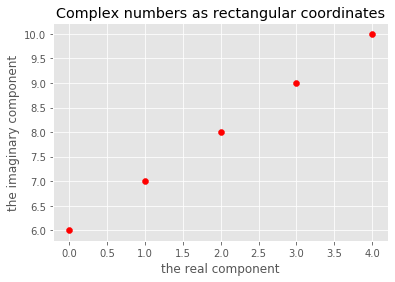

Looks just like any other x-y plot except in this case the x axis represents the real part
 and the y axis is the imaginary part


In [6]:
## Define a bunch of complex numbers:

## (6j, 1+7j, 2+8j, 3+9j, 4+10j]
complex_nums = np.arange(5) + 1j * np.arange(6,11)
print("A list containing five complex numbers:")
for c in complex_nums:
    print(complex_nums)

## Get the real parts of each complex number
A = [x.real for x in complex_nums]

## Get the imaginary parts of each complex number
B = [x.imag for x in complex_nums]

## Plot them, just like any other 2-D plot
plt.scatter(A,B, color='red')
plt.title("Complex numbers as rectangular coordinates")
plt.xlabel("the real component")
plt.ylabel("the imaginary component")
plt.show()
print("Looks just like any other x-y plot except in this case the x axis represents the real part\n and the y axis is the imaginary part")

## 2.3 Complex numbers and polar coordinates

So, we can represent complex numbers in the usual **rectangular** coordinate system (i.e. **Cartesian coordinates**).  That is,  $a + ib \mapsto (a, b)$, if we treat the 2nd coordinate as representing multiplication with $j$.  But, we can also represent points on a 2-D map in terms of **polar coordinates**.  That is in terms of angles ($\theta$) and magnitudes ($r$). 

This isn't something specific to complex numbers. It actually just falls out from the fact that we can represent complex numbers as a 2-D plane. You can use polar coordinates to easily represent complicated cyclic patterns that are a pain to represent in rectangular coordinates (pretty much anything involving anything circle like).

<div class="alert alert-warning">
    It's often easier to deal with angles measured in <strong>radians</strong> rather than <strong>degrees</strong>.  The main thing to note is that:
    $$2\pi \text{ radians} = 360 \text{ degrees, i.e. 1 full circle }$$
Again, it may not seem obvious why we should want to use radians instead of the more familiar degrees.  The reason is that it makes dividing up a circle really nice and neat and so ends up making calculations much easier in the long run!
</div>

Let's plot some complex numbers using polar coordinates:

In [4]:
## The python library for doing things with complex numbers is called cmath
## This allows us to easily convert between rectangular and polar coordinates

# Let's plot 8 points
N=8

## 2*pi Radians = 360 degrees
## Get a bunch of angles representing N points evenly spaced around a circle
## For N=8, each angle in radians in n*2pi/8
thetas = [(2*cmath.pi*n)/N for n in range(N)]
#print("thetas:", thetas)

## Generate some magnitudes, starting at 2 and decreases as i increase
rs = [2/(i+1) for i in range(N)]
#print("rs:", rs)

print("points in polar coordinates (r=magnitude, theta=angle):")
for r, theta in zip(rs, thetas):
    print("%f, %f" % (r, theta))

polar = plt.subplot(projection='polar')
polar.scatter(thetas, rs)
polar.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
polar.set_rmax(2.2)
polar.set_title("Complex numbers as polar coordinates: angles and magnitudes")



NameError: name 'cmath' is not defined

## 2.4 Going between polar and rectangular coordinates

Just as for regular vectors, we can go back and forth between coordinate types using some trignometric rules. 
Let's first let's check the conversion between polar coordinates to rectangular coordinates using some python complex number built in functions:

In [ ]:
## Convert the complex numbers from the plot above from polar coordinates to rectangular coordinates
cnums = [cmath.rect(rs[i], thetas[i]) for i in range(N)]

## Get the real parts of each complex number
X = [x.real for x in cnums]

## Get the imaginary parts of each complex number
Y = [x.imag for x in cnums]

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-2.2, 2.2), ylim=(-2, 2))

ax.plot([-2,2], [0,0], color='grey')
ax.plot([0,0],[-2,2], color='grey')
ax.scatter(X,Y, color='red')
ax.set_xlabel("the real component")
ax.set_ylabel("the imaginary component")
ax.set_title("polar coordinates to rectangular coordinates")


#print(cnums)

Looking closer at the second point: ($r=1, \theta=\pi/4$), we can derive the rectangular coordinates from the polar coordinates (and vice-versa)  using some trigonometry, since we're essentially looking at a right angled triangle.

### Conversion Formulae

You may remember learning the basic trigonometric relations  under the mnemonic: SOH CAH TOA, 

* SOH: $\sin(\theta) = \text{opposite}/\text{hypoteneuse}$:
* CAH: $\cos(\theta) = \text{adjacent}/\text{hypoteneuse}$:
* TOA: $\tan(\theta) = \text{opposite}/\text{adjacent}$: 


So, for a complex number $c = a + ib$ represented by rectangular coordinates $(a,b)$, we can calculate $r$ (i.e the hypoteneuse) and $\theta$ as follows:

$$ r = \sqrt{a^2 + b^2} $$
and
$$ \theta = \tan^{-1} \Big( \frac{b}{a} \Big)$$


Similarly, to go from polar coordinates $(r, \theta)$, we can use the following: 

For the real component:
$$a = r \cos(\theta) $$

For the imaginary component:
$$b = r \sin(\theta) $$


**Note** You don't have to memorize and trigonometric formulae for this course, but as always, developing your intuitions around these concepts will help understand digital signal processing better. 

### A geometric representation of the conversation formulae

The following graphs visualize the how the conversion formulae arise from the geometry of right angled triangles, using the 2nd point in the example above (magnitude=1, angle=$\pi/4$ radians = 45 degrees).


![Geometric representation of the conversion between rectangular and polar coordinates](./fig/polar_rect_conversion.png)

### Why do we want this imaginary bit? 

At this point, you may be asking yourself 'why not just use 2-d vectors? why bring this imaginary thing into it?'.
One important reason is that we can interpret multiplication by $j$ as a rotation by $\pi/2$ radians (90 degrees). If we keep multiply $j$ by itself, we go around in a circle eventually ending up where we started:

* $j^0 = 1$
* $j^1 = 1 \times j = j$
* $j^2 = j \times j = -1$
* $j^3 = -1 \times j = -j$
* $j^4 = -j \times j = 1$


Let's see what this looks like on the 2-D complex plane


In [ ]:
## Let's plot our powers of j from j^0  to j^4

## the imaginary number j
j = 1j

## the powers of j from 0 to 4
cnums = [1, j, j*j, j*j*j, j*j*j*j]

## Get the real and imaginary parts for plotting
cnums_real = np.array([cnum.real for cnum in cnums])
cnums_imag = np.array([cnum.imag for cnum in cnums])

print("powers of j:", cnums)
print("real part:",  cnums_imag)
print("imaginary part:", cnums_imag)

## Plot what happens when we keep multiplying j by itself
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-2.2, 2.2), ylim=(-2, 2))
ax.plot([-2,2], [0,0], color='grey')
ax.plot([0,0],[-2,2], color='grey')

# plot the points
ax.scatter(cnums_real,cnums_imag, color='red')

# add some labels
labels = [r'$j^0 = 1$', r'$j^1 = j$', r'$j^2=-1$', r'$j^3 = -j$']
for i, txt in enumerate(labels):
    ax.annotate(txt, (cnums_real[i]-0.3, cnums_imag[i]+0.1),  fontsize=14)
ax.annotate(r'$j^4 = 1$' , (cnums_real[4]-0.3, cnums_imag[4]-0.3),  fontsize=14)

# label the axes
ax.set_xlabel("the real component")
ax.set_ylabel("the imaginary component")
ax.set_title("multiplication by imaginary j as a 90 degree rotation")

You should see that if we continue to multiply $j$ by itself we just keep rotating 90 degrees ($\pi/2$ radians) around the the origin (0,0). This rotation property turns out to be really useful in signal processing (and electric engineering more generally). 

## 2.5 Euler's Formula

We can express the relationship between complex numbers in polar and rectangular coordinates in a very neat way using **Euler's formula**: 


$$ e^{j \varphi} = \cos(\varphi) + j \sin(\varphi) $$

So, $e^{j \varphi}$ is the complex number with magnitude $r=1$ and angle $\theta = \varphi$.  That is, if we trace this out for all possible values of $\varphi$ we draw out a circle centered at (0,0) with radius 1, i.e. the **unit circle**

This means that: 

$$ R e^{i \varphi} = R(\cos(\varphi) + j \sin(\varphi)) $$

is the complex number with magnitude $R$ and angle $\varphi$. So, if we draw this value for values of $\varphi$ between 0 and $2\pi$ radians, we get a circle centered at (0,0) with radius $R$.

Let's see a plot of this:

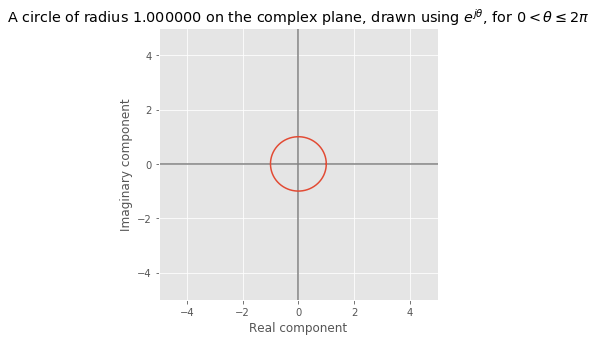

In [7]:
## Take a bunch of angle values from 0 to 2pi (one full circles)
theta_max = 2*np.pi
theta_min = 0
theta_step = 0.01
thetas = np.arange(theta_min, theta_max, theta_step)

## the radius r: try changing this
R = 1

## Generate sequence of complex numbers with r=1, theta=theta, for theta in thetas
zs = R*np.exp(1j*thetas)

## Now get the real and imaginary component (i.e. the rectangular coordinates)
zs_real = np.real(zs)
zs_imag = np.imag(zs)

## Plot it! 
fig, ax = plt.subplots(figsize=(5, 5))

## Some axes in grey
ax.plot([-5,5], [0,0], color='grey')
ax.plot([0,0],[-5,5], color='grey')
ax.set(xlim=(-5, 5), ylim=(-5, 5))

## The complex numbers
ax.plot(zs_real, zs_imag)

## Some labels
ax.set_ylabel('Imaginary component')
ax.set_xlabel('Real component')
axt = ax.set_title('A circle of radius %f on the complex plane, drawn using $e^{j\\theta}$, for $0 < \\theta \leq 2\\pi$' % R)


### Exercise

* Try varying the `R` value in the plot above and see how this changes the radius of the circle centered at (0,0).
* How might you draw a circle that wasn't centered at (0,0)?

## 2.6 Plotting sine waves from complex numbers

### Phasors: From Complex numbers  to Sinusoids 

The most important we'll take away from Euler's formula is that we can use it to describe a sinusoid varying in amplitude over time.  Instead of thinking of an endless time vs amplitude graph, we can think of the sinusoid in terms a fixed length vector rotating around the a point a on the complex plane - something like an analogue clockface.  We'll call this sort of rotating vector a **phasor**, where think of the vector $re^{jt}$ as a single hand (length $r$) ticking around it.

When we think about phasors, we have to start thinking about changes over time for a waveform as a change in a phasor's angle with respect to the real (horizontal) and imaginary (vertical) axes on the complex plane. 

If we go back to Euler's formula: 

$$ e^{jt} = \cos(t) + j \sin(t) $$ 

We see that $e^{jt}$ is just a complex number and also: 

$$ \cos(t) = \text{Real}(e^{jt}) $$
and
$$ \sin(t) = \text{Imag}(e^{jt}) $$

What this means is that a sine wav, $\sin(t)$, is just the projection of $e^{jt}$ onto the imaginary (vertical) axis, and $\cos(t)$ is the projection of $e^{jt}$ onto the real (horizontal) axis.  

But this is all very abstract! It's much easier to see if we visualize what happens as we vary $t$...


In [64]:
## Plot a phasor and a corresponding sine wave 

## First, let's set up a sequence of theta steps (angles around a circle).  Changes in the time for a sine wave as equivalent to change in angle 
## for the phasor

theta_max = 7
theta_min = 0
theta_step = 0.23
thetas = np.arange(theta_min, theta_max, theta_step)

R=1

## Generate sequence of complex numbers with r=1, theta=theta, for theta in thetas
zs = R*np.exp(1j*thetas)
#print("zs:")
#print(zs)

## Get the real and imaginary parts to plot in rectangular coordinates
# Using numpy built-in functions
As = np.real(zs)
Bs = np.imag(zs)


Text(0.5, 0, 'Time ($t$ radians = $t$ seconds) ')

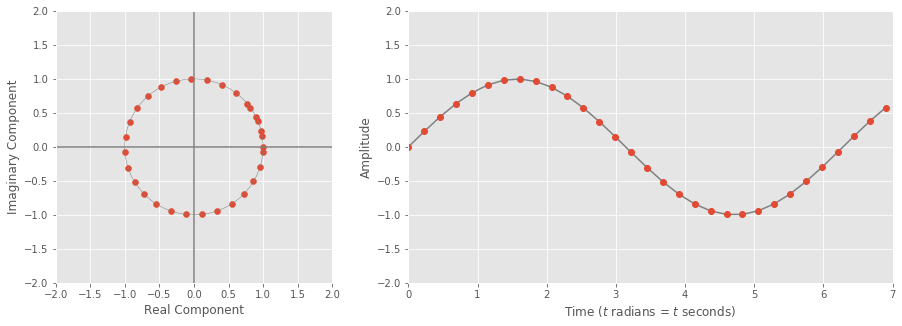

In [65]:
## Plot the phasor and sinusoid

## Make 2 figures, a phasor on the left and the corresponding sinusoid on the right
fig, (phasor, sinusoid) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 7]}, figsize=(15,5))
phasor.set(xlim=(-2, 2), ylim=(-2, 2))

## plot the phasor: these are our complex zs values, i.e. e^(j*theta)
## Since we set the magnitude to r=1, all these points sit nicely on the unit circle

## Add in some axes lines
phasor.plot([-2,2], [0,0], color='grey')
phasor.plot([0,0],[-2,2], color='grey')

## Plot the unit circle in grey just to check 
circle1 = plt.Circle((0, 0), 1, color='grey',fill=False)
phasor.add_artist(circle1)

## plot our complex numbers (rectangular coordinates)
phasor.scatter(As, Bs)

## Some labels for the left hand plot
phasor.set_xlabel("Real Component")
phasor.set_ylabel("Imaginary Component")


## plot the sinusoid on the right: sin(theta)
## The x-axis represents our theta values (think of this as time)
## The y-axis is sin(theta)
sinusoid.set(xlim=(theta_min, theta_max), ylim=(-2, 2))
sinusoid.plot(thetas, np.sin(thetas), color='grey')
sinusoid.plot(thetas, Bs, 'o')

## Some labels for the right hand plot
sinusoid.set_ylabel("Amplitude")
sinusoid.set_xlabel("Time ($t$ radians = $t$ seconds) ")


The plot above shows a phasor  and it's corresponding sine wave (i.e. imaginary component) projection over a specific time range (0 to 7 radians).  The points on phasor (left) all lie on the unit circle, while the projection (right) looks like like like a sine wave over time. You'll see after $2\pi \approx 6.3$ radians, the phasor has completed one cycle and the sine wave starts to repeat itself.

### Let's get moving! 
It's a bit hard to see the relationship in time as a static graph, so let's make an animated version:

In [66]:
## plot the relationship between the sinusoid and cycle of the unit circle on the complex plane

## Generate coordinates to draw a vector representation (i.e. the clock hand) of the points on the phasor 
## i.e. a line from (0,0) to (x,y)
n_samples = As.shape[0]
A = np.array(As).reshape(n_samples, 1)
B = np.array(Bs).reshape(n_samples, 1)
zeros = np.zeros(n_samples).reshape(n_samples, 1)
A = np.concatenate([zeros, A], axis=1)
B = np.concatenate([zeros, B], axis=1)    

## Some initialization
line = phasor.plot([], [], color='b', lw=3)[0]
point = phasor.plot([], [], 'o', color='b',  markersize=10)[0]
sin_t = sinusoid.plot([], [], 'o', color='b', markersize=10)[0]

## Set axes lables
phasor.set_xlabel("Real Component")
phasor.set_ylabel("Imaginary Component")
sinusoid.set_xlabel("Time ($t$ radians = $t$ seconds) ")
sinusoid.set_ylabel("Amplitude")


## Do the animation!
def anim_sinusoid(i):
    t = thetas[i]
    line.set_data(A[i, :], B[i,:])
    point.set_data(A[i, 1], B[i,1])
    sin_t.set_data(t, B[i, 1])

anim = FuncAnimation(
    fig, lambda x: anim_sinusoid(x), interval=600, frames=n_samples)
 
## This might take a little while to start rendering
HTML(anim.to_html5_video())


In [67]:
#anim.save("phasor.gif",  writer='imagemagick') 

### Exercise
* Q: What happens if you increase `theta_max`? 
* Q: What if you decrease the minimum `theta_min`


### Notes

In [32]:
# Increasing theta_max increases the points of the graph and thus squishing the wave
# Decreasing theta_min shifts the graph

### Exercise

The example above assumed that each angular step around the phasor, $\theta$, was equivalent to $\theta$ seconds (i.e. a step of $\pi/2$ radians takes $\pi/2$ seconds.  What's the frequency of the sine wave in the above animation? 


### Notes

In [ ]:
# 1/7 Hz

### Take it easy with $e^{j\theta}$

Why use this phasor representation? At this point you may be wondering why not just directly use $\sin(t)$ and $\cos(t)$?  Well, it turns out that using this polar coordinate based representation for complex numbers (and hence our trig functions like sine and cosine) makes life a lot easier in many ways: 

* We can think of multiplication of two complex numbers as a rotation: $e^{j \varphi} \times e^{j \theta} = e^{i (\varphi + \theta)}$
    * That is, we just rotate the original complex number, $e^{j \varphi}$, $\theta$ degrees around the origin (0,0).
    * If $\theta > 0$ we rotate counterclockwise, and if $\theta < 0$ we rotate clockwise.
    * You just add the angles!
    
* Multiplication by a scalar is just a change of magnitude (stretch away from, or shrinking to the origin. 

* Calculus is also now way easier since we know that: 
$$\frac{d e^{x}}{dx} = e^{x}$$
   
This makes the Fourier Transform (and so pretty much all of signal processing) way easier to deal with!